# UMAP each image separately


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
import cv2
import skimage
import tifffile as tf
import os
import pandas as pd
#import napari
#print(napari.__version__)
#from dask_image.imread import imread
#import dask.array as da
#import io

import platform
if platform.system() == 'Windows':
    fileroot = 'X:/'
    print('Loading Windows')
if platform.system() == 'Linux':
    fileroot = '/home/jovyan/'
    print('Loading Linux')
if False:
    fileroot = '/home/ubuntu/Documents/'
if os.path.exists('/nfs/team283_imaging/') and not os.path.exists('/home/jovyan/'):
    fileroot = '/nfs/team283_imaging/'

colors_new=['#0072b2','#d55e00','#009e73', '#cc79a7','#f0e442','#56b4e9']

import sys
sys.path.append(fileroot+'VU_TEX/Ben_utilities/')
import useful_functions as uf
import numba_funcs as nf

Loading Linux


In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from tqdm import tqdm, trange
from matplotlib.colors import to_rgba
#import hdbscan
import umap
from tqdm import tqdm, trange
import fastremap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from numba import njit
import scipy
import pickle

In [3]:
import seaborn as sns

In [4]:
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 100)

### Load data

In [5]:
#directory_images_metadata = fileroot + 'team283_imaging/' + '0ExternalData/2022-09-01_IVY_GAP/'
#directory_images_metadata = fileroot + '0ExternalData/2022-09-01_IVY_GAP/'
#filename_images_metadata = '2022-09-01_IVY_GAP_metadata.csv'
#df_images_metadata = pd.read_csv(directory_images_metadata + filename_images_metadata, index_col=0)
#df_images_metadata = df_images_metadata.loc[df_images_metadata['original_index'].isin([50, 594, 406, 418, 
#267, 290, 474, 231, 498, 217, 
#309, 544])]
#df_images_metadata
directory_originals = [fileroot + 'VU_TEX/playground_Ben/2023-07-05_Thymus/2023-07-06d_image_conversion_and_crop_to_small_version/']
filenames_originals = ['V11J11-099__Z4_FO3_01__A1_small.tif']
fullpaths_originals = [directory_originals[0] + filenames_originals[0]]

df_images_metadata = pd.DataFrame({'original_index': [0], 'output_filename':filenames_originals, 
                                 })
this_shape = skimage.io.imread(fullpaths_originals[0]).shape
df_images_metadata['image_width'] = this_shape[0]
df_images_metadata['image_height'] = this_shape[1]
df_images_metadata

,original_index,output_filename,image_width,image_height
0,0,V11J11-099__Z4_FO3_01__A1_small.tif,5539,3739


In [6]:
#directory_colors_metadata = fileroot + 'team283_imaging/' + '0ExternalData/2022-09-01_IVY_GAP/'
#directory_colors_metadata = fileroot + '0ExternalData/2022-09-01_IVY_GAP/'
#filename_colors_metadata = '2022-09-02_colors_for_IVY_GAP.csv'
#df_colors = pd.read_csv(directory_colors_metadata + filename_colors_metadata, index_col=0)
#df_colors

#mycolors = uf.return_color_scale('block_colors_for_labels_against_white_small_points')

In [7]:
#for i, each in enumerate(df_colors['colorblind_optimized']):
#    print(i)
#    uf.make_Ramp_flexible([each, each])
#    plt.show()

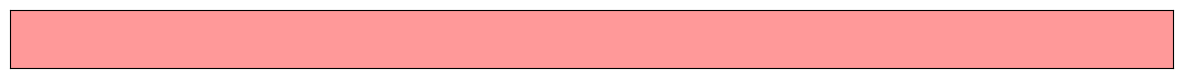

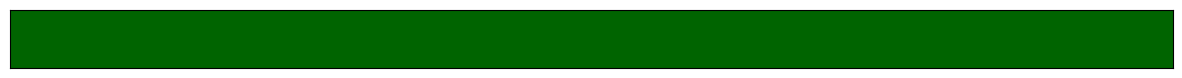

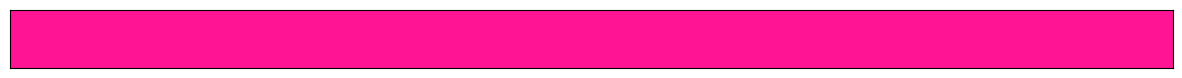

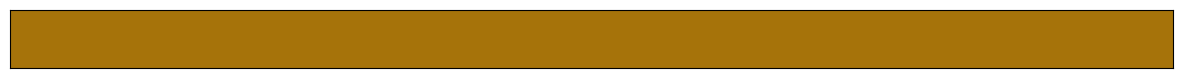

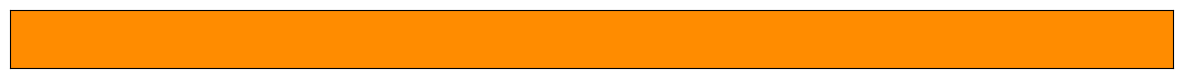

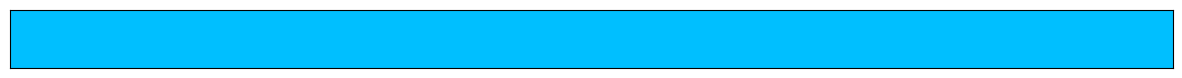

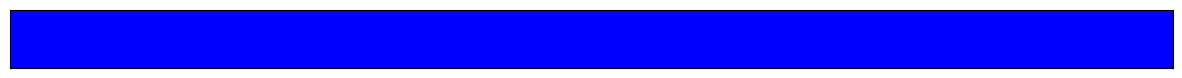

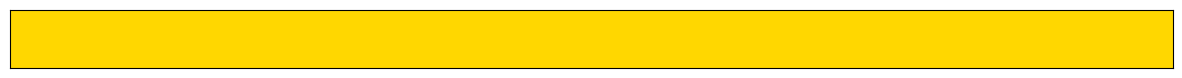

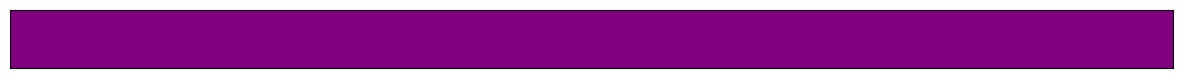

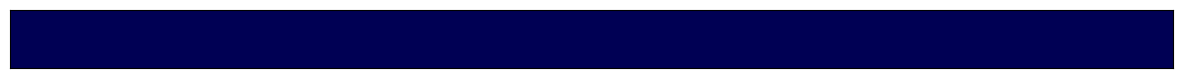

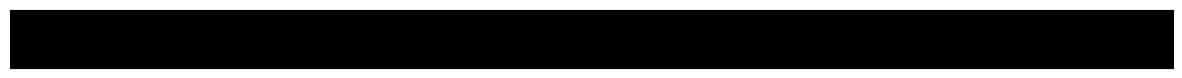

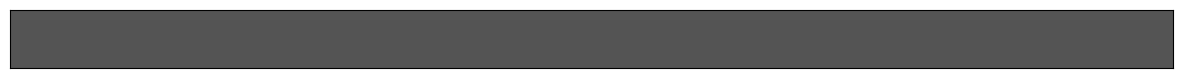

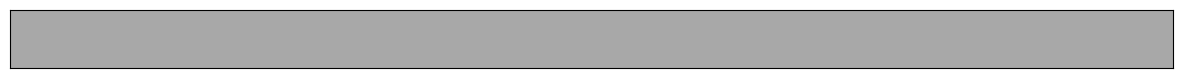

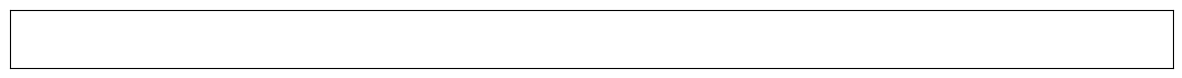

In [8]:
#mycolors = list(df_colors['colorblind_optimized'])
mycolors = uf.return_color_scale('block_colors_for_labels_against_white_small_points')

In [9]:
#directory_X = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-09-23_LBP_tiled_pipeline/'
#filename_X = '2022-10-13_LBP_all_images_data_X_up_to_radius_34.npy'
#X = np.load(directory_X + filename_X, mmap_mode='r')

In [10]:
directory_X_scaled = ''
#directory_X_scaled = '/lustre/scratch117/cellgen/team283/bw17/VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-09-23_LBP_tiled_pipeline/'
filename_X_scaled = '2023-07-07_LBP_all_images_data_X.npy'
X = np.load(directory_X_scaled + filename_X_scaled, mmap_mode='r')
X.shape, X.dtype

((2035, 6051), dtype('uint16'))

In [11]:
start = datetime.now(); print(start)
directory_OBS = ''
filename_OBS = '2023-07-07_LBP_all_images_data_OBS.csv'
df_OBS = pd.read_csv(directory_OBS + filename_OBS, index_col=0)
df_OBS['Groundtruth'] = pd.Categorical(df_OBS['Groundtruth'])
df_OBS['original_index'] = pd.Categorical(df_OBS['original_index'])
display(df_OBS)
datetime.now()-start

2023-07-07 13:52:55.429308


,this_image_index,X0,X1,Groundtruth,original_index,output_filename
0,0,0,0,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
1,1,0,1,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
2,2,0,2,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
3,3,0,3,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
4,4,0,4,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
...,...,...,...,...,...,...
2030,2030,54,32,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
2031,2031,54,33,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
2032,2032,54,34,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
2033,2033,54,35,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif


datetime.timedelta(microseconds=25649)

In [12]:
pd.unique(df_OBS['original_index'])

[0]
Categories (1, int64): [0]

In [13]:
directory_VAR = ''
filename_VAR = '2023-07-07_LBP_all_images_data_VAR.csv'
df_VAR = pd.read_csv(directory_VAR + filename_VAR, index_col=0)
df_VAR.index = df_VAR.index.astype(str)
df_VAR

,0
0,Ch_0_METHOD_uniform_npoints_7_radius_1_value_0
1,Ch_0_METHOD_uniform_npoints_7_radius_1_value_1
2,Ch_0_METHOD_uniform_npoints_7_radius_1_value_2
3,Ch_0_METHOD_uniform_npoints_7_radius_1_value_3
4,Ch_0_METHOD_uniform_npoints_7_radius_1_value_4
...,...
6046,Ch_2_METHOD_uniform_npoints_497_radius_79_valu...
6047,Ch_2_METHOD_uniform_npoints_497_radius_79_valu...
6048,Ch_2_METHOD_uniform_npoints_497_radius_79_valu...
6049,Ch_2_METHOD_uniform_npoints_497_radius_79_valu...


In [14]:
dict_colors = {0:to_rgba(mycolors[0]), 
               1:to_rgba(mycolors[1]), 
               2:to_rgba(mycolors[2]),
               3:to_rgba(mycolors[3]),
               4:to_rgba(mycolors[4]),
               5:to_rgba(mycolors[5]),
               6:to_rgba(mycolors[6]),
               7:to_rgba(mycolors[7]),
               8:to_rgba(mycolors[8]),
               9:to_rgba(mycolors[9]),
              np.nan:(1, 1, 1)
              }

dict_color_names = {0:mycolors[0], 
               1:mycolors[1], 
               2:mycolors[2],
               3:mycolors[3],
               4:mycolors[4],
                5:mycolors[5],
               6:mycolors[6],
                7:mycolors[7],
               8:mycolors[8],
                  9:mycolors[9],  
              np.nan:(1, 1, 1)
                   }

#mycolors_list_all = anndata_concat.obs['Groundtruth'].map(dict_color_names)
#mycolors_list_all_ilastik = df_all['Pathology'].map(dict_color_names)
#mycolors_list_all

  0%|                                                                                                         | 0/1 [00:00<?, ?it/s]

2035


/opt/conda/envs/lbp3c/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/lbp3c/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


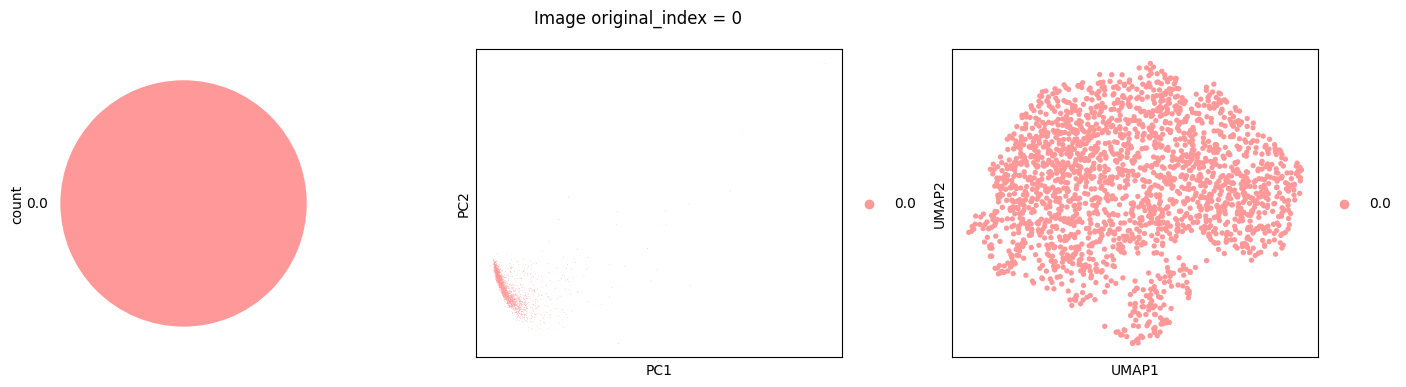

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.51s/it]


In [15]:
for img_original_index in tqdm([0]):
    list_of_index_img0 = df_OBS.index[(df_OBS['original_index'].isin([img_original_index])) &
                                 (~df_OBS['Groundtruth'].isin([]))]
    print(len(list_of_index_img0))
    this_df = df_OBS.loc[list_of_index_img0]
    this_df.index = this_df.index.astype(str)
    anndata_concat = ad.AnnData(X=X[list_of_index_img0], obs=this_df, var=df_VAR, dtype=np.float32)
    Groundtruth_vc = anndata_concat.obs['Groundtruth'].value_counts()
    anndata_concat.obs['Groundtruth'] = anndata_concat.obs['Groundtruth'].cat.set_categories(list(Groundtruth_vc.index[Groundtruth_vc > 0]))
    sc.pp.scale(anndata_concat)
    
    z = [dict_colors[each] for each in list(anndata_concat.obs['Groundtruth'].value_counts().index)]
    fig, ax = plt.subplots(1,3, figsize=(17,4))
    Groundtruth_vc.plot(kind='pie', colors=z, ax=ax[0])
    sc.tl.pca(anndata_concat, svd_solver='auto')
    sc.pl.pca(anndata_concat, color='Groundtruth',
                 size=1, palette=dict_colors, components=['1,2'], ax=ax[1], show=False, title='')
    sc.pp.neighbors(anndata_concat, n_neighbors=5, n_pcs=None)
    sc.tl.umap(anndata_concat) #, min_dist=0.0
    sc.pl.umap(anndata_concat, color=['Groundtruth'],          
         palette=dict_colors, show=False, alpha=1, ax=ax[2], title='')
    plt.suptitle('Image original_index = ' + str(img_original_index))
    plt.subplots_adjust(wspace=0.3)
    plt.show()
#    break